Setup environment and load the base PyPSA-Earth network for a specified country.


In [46]:
# General Factors for scenario testing
SNAPPING_H = 1
SCALING_FACTOR = 23/49.2

In [47]:
# --- Core imports
import os
import sys
import copy
import logging
import warnings
from os.path import join
from pathlib import Path

# --- Numerical / data
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

# --- Power systems / geospatial
import pypsa
import atlite
from shapely.geometry import Point, box
from shapely.ops import unary_union
import shapely

# Optional plotting (only used in helper plot function)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Optional: powerplantmatching (picks up config but we keep local CSV as source of truth)
try:
    import powerplantmatching as pm
    HAVE_PPM = True
except Exception:
    HAVE_PPM = False

# --- Silence noisy warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.filterwarnings('ignore')


# --- Logging
parent_dir = Path(os.getcwd()).parents[0]          # project/
LOG_FILE = join(parent_dir, "logs.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[logging.FileHandler(LOG_FILE, encoding="utf-8"), logging.StreamHandler(sys.stdout)],
)
logger = logging.getLogger(__name__)

# --- Project paths helper
sys.path.append(str(parent_dir))
from src.paths import all_dirs  # must exist in your repo
dirs = all_dirs()

# --- Add PyPSA-Earth scripts to PATH (assumes repo layout: <project>/../pypsa-earth/scripts)
scripts_path = os.path.join(parent_dir.parents[0], "pypsa-earth", "scripts")
assert os.path.isdir(scripts_path), f"Path not found: {scripts_path}"
sys.path.append(scripts_path)



In [48]:
# 1) Load Networks
network_dir = dirs["data/processed/networks"]
network_files = [
    "network_original",
    "network_snapped",
    "network_expanded",
    "network_expanded_no_orphans",
    "network_nuclear",
    "network_prod_mix",
    "network_base",
]

logger.info("Loading .nc networks …")
networks_dict = {}
for nf in network_files:
    f = join(network_dir, f"{nf}.nc")
    if os.path.isfile(f):
        try:
            networks_dict[nf] = pypsa.Network(f)
            logger.info(f"  ✓ loaded {nf}.nc")
        except Exception as e:
            logger.warning(f"  ⚠ failed to load {nf}.nc: {e}")
    else:
        logger.warning(f"  ⚠ missing file: {f}")

# Work on a copy of the base network
assert "network_base" in networks_dict, "network_base.nc not found/loaded."
network = networks_dict["network_base"].copy()


2025-11-13 17:27:47: Loading .nc networks …
2025-11-13 17:27:48: Imported network network_original.nc has buses, lines, transformers
2025-11-13 17:27:48:   ✓ loaded network_original.nc
2025-11-13 17:27:48: Imported network network_snapped.nc has buses, lines, transformers
2025-11-13 17:27:48:   ✓ loaded network_snapped.nc
2025-11-13 17:27:48: Imported network network_expanded.nc has buses, lines, transformers
2025-11-13 17:27:48:   ✓ loaded network_expanded.nc
2025-11-13 17:27:48: Imported network network_expanded_no_orphans.nc has buses, lines, transformers
2025-11-13 17:27:48:   ✓ loaded network_expanded_no_orphans.nc
2025-11-13 17:27:49: Imported network network_nuclear.nc has buses, lines, transformers
2025-11-13 17:27:49:   ✓ loaded network_nuclear.nc
2025-11-13 17:27:49: Imported network network_prod_mix.nc has buses, lines, transformers
2025-11-13 17:27:49:   ✓ loaded network_prod_mix.nc
2025-11-13 17:27:49: Imported network network_base.nc has buses, lines, transformers
2025-11

In [49]:
def prune_network_min_voltage(n, v_threshold_kv=137.0):
    """
    Keep only buses with v_nom >= v_threshold_kv and remove any components
    (transformers, lines, links, loads, generators, stores, storage_units, shunts)
    that reference removed buses.
    """
    import numpy as np
    n = n.copy()

    # 1) Decide which buses to keep
    buses_orig = n.buses.index.astype(str)
    keep_buses = n.buses.index[n.buses["v_nom"] >= float(v_threshold_kv)].astype(str)
    keep_set   = set(keep_buses)
    drop_set   = set(buses_orig) - keep_set

    print(f"Keeping {len(keep_buses)}/{len(buses_orig)} buses (v_nom >= {v_threshold_kv} kV).")
    if drop_set:
        print(f"Dropping {len(drop_set)} buses due to voltage threshold.")

    # helper to drop rows by bus column name if bus not in keep_set
    def _drop_by_bus(df, bus_col):
        if df.empty or bus_col not in df.columns:
            return df.index[:0]
        mask = ~df[bus_col].astype(str).isin(keep_set)
        return df.index[mask]

    # 2) Collect components to drop because they reference removed buses
    to_drop = {
        "Load":          _drop_by_bus(n.loads, "bus"),
        "Generator":     _drop_by_bus(n.generators, "bus"),
        "Store":         _drop_by_bus(getattr(n, "stores"), "bus") if hasattr(n, "stores") else [],
        "StorageUnit":   _drop_by_bus(n.storage_units, "bus") if hasattr(n, "storage_units") else [],
        "ShuntImpedance": _drop_by_bus(getattr(n, "shunt_impedances"), "bus") if hasattr(n, "shunt_impedances") else [],
        "Line":          n.lines.index[
                            ~n.lines["bus0"].astype(str).isin(keep_set) |
                            ~n.lines["bus1"].astype(str).isin(keep_set)
                        ],
        "Transformer":   n.transformers.index[
                            ~n.transformers["bus0"].astype(str).isin(keep_set) |
                            ~n.transformers["bus1"].astype(str).isin(keep_set)
                        ],
        "Link":          n.links.index[
                            ~n.links["bus0"].astype(str).isin(keep_set) |
                            ~n.links["bus1"].astype(str).isin(keep_set)
                        ] if len(n.links) else []
    }

    # 3) Remove them from the network using PyPSA's API
    for comp, idx in to_drop.items():
        idx = list(idx)
        if not idx:
            continue
        for name in idx:
            try:
                n.remove(comp, name)
            except Exception as e:
                # be robust if component table missing etc.
                pass
        print(f"Removed {len(idx):4d} {comp}(s) referencing dropped buses.")

    # 4) Finally, restrict the buses table itself to the kept set
    n.buses = n.buses.loc[keep_buses]

    # Optional: clean orphaned carriers/sub-networks etc. if needed

    return n

# ---- use it ----
network = prune_network_min_voltage(networks_dict["network_base"], v_threshold_kv=137)
                                    #137.0)



Keeping 111/296 buses (v_nom >= 137 kV).
Dropping 185 buses due to voltage threshold.
Removed  141 Line(s) referencing dropped buses.
Removed   43 Transformer(s) referencing dropped buses.


In [50]:
# 2) Loads: add p_set time series
# 2) Loads: add p_set time series with nearest-bus remapping for unknown buses
try:
    path_loads = dirs["data/processed/scaled_loads"]
    load_profile_name = "load_base_2030_linear.csv"
    load_profile_file = join(path_loads, load_profile_name)
    logger.info(f"Loading load profile: {load_profile_file}")
    load_profile = pd.read_csv(load_profile_file, index_col=0, parse_dates=True)
    scaling_factor = SCALING_FACTOR
    load_profile = load_profile*scaling_factor
    logger.info(f"Scaled all load profile values by factor {scaling_factor}")
    # --- Ensure column names are strings
    load_cols = [str(c) for c in load_profile.columns]
    load_profile.columns = load_cols

    # --- Existing buses in the active network
    buses_now = network.buses.copy()
    buses_now.index = buses_now.index.astype(str)
    existing_buses = set(buses_now.index)

    # --- Find missing bus labels
    missing = [c for c in load_cols if c not in existing_buses]
    if missing:
        logger.warning(f"{len(missing)} load buses not found; reassigning to nearest existing bus.")
    else:
        logger.info("All load buses found in current network.")

    # --- Build KDTree on current network buses
    from scipy.spatial import cKDTree as KDTree
    use_lonlat = {"lon", "lat"}.issubset(buses_now.columns)
    if use_lonlat:
        coords_now = buses_now.loc[:, ["lon", "lat"]].to_numpy(dtype=float)
    else:
        coords_now = buses_now.loc[:, ["x", "y"]].to_numpy(dtype=float)
    kdt_now = KDTree(coords_now)

    # --- Helper: try to get coordinates for a missing bus from any fallback network
    def find_bus_coords_in_fallbacks(bus_name: str):
        for nf, net_fb in networks_dict.items():
            try:
                df = net_fb.buses.copy()
                df.index = df.index.astype(str)
                if bus_name in df.index:
                    if {"lon", "lat"}.issubset(df.columns):
                        return ("lonlat",
                                float(df.loc[bus_name, "lon"]),
                                float(df.loc[bus_name, "lat"]))
                    elif {"x", "y"}.issubset(df.columns):
                        return ("xy",
                                float(df.loc[bus_name, "x"]),
                                float(df.loc[bus_name, "y"]))
            except Exception:
                pass
        return None

    # --- Build a bus assignment vector aligned with load columns
    bus_assignments = []
    remap_report = []

    for c in load_cols:
        if c in existing_buses:
            bus_assignments.append(c)  # unchanged
            continue

        # Try to recover coordinates for this bus label from other networks
        info = find_bus_coords_in_fallbacks(c)
        if info is not None:
            kind, bx, by = info
            # Query KDTree (always built for current network in the coordinate type we have)
            if use_lonlat and kind == "lonlat":
                q = np.array([[bx, by]])
            elif (not use_lonlat) and kind == "xy":
                q = np.array([[bx, by]])
            else:
                # Coordinate kind mismatch; cannot reliably transform → use crude nearest by lon/lat if both exist,
                # else by x/y. If mismatch, try whichever exists in current network.
                if use_lonlat and kind == "xy":
                    # We only have xy for missing, but KDTree is lon/lat → fallback to closest by index 0
                    # (transparent about this in logs)
                    remap_report.append((c, None, None, "coord_kind_mismatch"))
                    # Pick the closest *by index* fallback: use network's geometric center
                    # (KDTree needs a point; we’ll use median lon/lat)
                    q = np.nanmedian(coords_now, axis=0)[None, :]
                elif (not use_lonlat) and kind == "lonlat":
                    remap_report.append((c, None, None, "coord_kind_mismatch"))
                    q = np.nanmedian(coords_now, axis=0)[None, :]
                else:
                    q = np.nanmedian(coords_now, axis=0)[None, :]
            idx = int(kdt_now.query(q)[1][0])
            nearest_bus = buses_now.index[idx]
            bus_assignments.append(nearest_bus)
            remap_report.append((c, bx, by, f"mapped_to:{nearest_bus}"))
        else:
            # No coordinates found anywhere → attach to globally nearest by network centroid
            idx = int(kdt_now.query(np.nanmedian(coords_now, axis=0)[None, :])[1][0])
            nearest_bus = buses_now.index[idx]
            bus_assignments.append(nearest_bus)
            remap_report.append((c, None, None, f"mapped_to:{nearest_bus};reason:no_coords"))

    if remap_report:
        logger.info("Load bus remapping performed (missing → nearest existing):")
        for r in remap_report:
            logger.info(f"  load '{r[0]}' → {r[3]} (src_coords: {r[1]}, {r[2]})")

    # --- Finally add Loads with reassigned buses
    network.madd("Load", load_cols, bus=bus_assignments, p_set=load_profile)

    # Peak (GW)
    peak_load = round(network.loads_t.p_set.T.sum().max() / 1000, 1)
    logger.info(f"Peak load in p_set time series: {peak_load} GW")

except Exception as e:
    logger.warning(f"Could not attach loads: {e}")



2025-11-13 17:27:49: Loading load profile: c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\processed\scaled_loads\load_base_2030_linear.csv
2025-11-13 17:27:49: Scaled all load profile values by factor 0.46747967479674796
2025-11-13 17:27:49: 202 load buses not found; reassigning to nearest existing bus.
2025-11-13 17:27:49: Load bus remapping performed (missing → nearest existing):
2025-11-13 17:27:49:   load '0' → mapped_to:1 (src_coords: -78.6904, -1.6524)
2025-11-13 17:27:49:   load '2' → mapped_to:3 (src_coords: -80.8895, -2.2304)
2025-11-13 17:27:49:   load '6' → mapped_to:7 (src_coords: -78.5372, -0.3652)
2025-11-13 17:27:49:   load '9' → mapped_to:10 (src_coords: -78.6094, -0.7952)
2025-11-13 17:27:49:   load '13' → mapped_to:14 (src_coords: -78.6035, -1.2217)
2025-11-13 17:27:49:   load '15' → mapped_to:16 (src_coords: -79.9019, -2.2414)
2025-11-13 17:27:49:   load '18' → mapped_to:19 (src_coords: -76.9995, -0.4292)
2025-11-13 17:27:49:   load '20' → mapped_

In [51]:
# ======================================================================
#                      3) Power plants table (CSV)
# ======================================================================
ppl_csv = join(dirs["data/processed/generation"], "powerplants_all.csv")
assert os.path.isfile(ppl_csv), f"Power plants CSV not found: {ppl_csv}"
ppl_raw = pd.read_csv(ppl_csv, index_col=0)

# --- OPTIONAL (recommended): normalize using powerplantmatching
ppl = ppl_raw.copy()
try:
    import powerplantmatching as pm

    # Load PPM config (pypsa-earth config shipped in your repo)
    ppmatching = os.path.join(
        Path(os.getcwd()).parents[1], "pypsa-earth", "configs", "powerplantmatching_config.yaml"
    )
    print(ppmatching)
    config = pm.get_config(ppmatching)
    config["target_countries"] = ["EC"]  # Ecuador

    # These utilities are in pm.powerplant
    # 1) fill missing commissioning years
    ppl_f = ppl.powerplant.fill_missing_commissioning_years()
    # 2) convert to PyPSA-compatible column names (bus/generator naming conventions)
    ppl_p = ppl_f.powerplant.to_pypsa_names()

        # Drop all-empty columns that may be introduced by upstream merges
    ppl = ppl_p.dropna(axis=1, how="all")

    logger.info("Applied powerplantmatching normalization (fill years + to_pypsa_names).")
except Exception as e:
    logger.warning(f"powerplantmatching step skipped (using raw CSV): {e}")
    ppl = ppl_raw.copy()


ppl.columns

# ---- Normalize capacities and carriers (ES->EN) on the (possibly PPM-normalized) table
def _normalize_text(s):
    import unicodedata, re
    if pd.isna(s):
        return None
    s = str(s).strip().lower()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"\s+", " ", s)
    return s

# capacity as float (handles "1'500,00")
if "p_nom" in ppl.columns:
    ppl["p_nom"] = (
        ppl["p_nom"].astype(str).str.replace("'", "", regex=False).str.replace(",", ".", regex=False)
    )
    ppl["p_nom"] = pd.to_numeric(ppl["p_nom"], errors="coerce").fillna(0.0)
else:
    logger.warning("Column 'p_nom' not found in plants table after normalization.")

# map carriers
if "carrier" in ppl.columns:
    ppl["carrier_norm"] = ppl["carrier"].apply(_normalize_text)
    carrier_map_es2en = {
        "hidraulica": "hydro",
        "hidroelectrico": "hydro",
        "termica": "oil",            # general fallback, could also be "natural gas" or "coal" depending on subtype
        "termoelectrico": "oil",
        "biomasa": "biomass",
        "fotovoltaica": "solar",
        "solar": "solar",
        "eolica": "onwind",
        "eolico": "onwind",
        "biogas": "biomass",         # or "biogas" if you keep it distinct later
        "ernc": "onwind",            # “Energía Renovable No Convencional”, usually wind/solar, adjust if needed
        "nuclear": "nuclear",
        "geotermica": "geothermal",
        "carbón": "coal",
        "carbon": "coal",
        "lignito": "lignite",
        "gas natural": "natural gas",
        "gas": "natural gas",
        "phs": "PHS",
        "pasada": "ror",             # hydro run-of-river
        "embalse": "hydro",          # reservoir-type hydro
        "offshore": "offwind-ac",    # adjust if you know DC vs AC
        "offshore_dc": "offwind-dc",
    }
    ppl["carrier"] = ppl["carrier_norm"].map(carrier_map_es2en).fillna(ppl["carrier_norm"])
else:
    logger.warning("Column 'carrier' not found in plants table after normalization.")

# ---- Filter: SNI, by year and minimum size
FILTERING_POWER = 0.0   # kW threshold
DATE_IN = 2017
if {"component", "DateIn", "p_nom"}.issubset(ppl.columns):
    ppl_connected = ppl[ppl["component"] == "S.N.I."]
    ppl_connected_current = ppl_connected[ppl_connected["DateIn"] <= DATE_IN]
    ppl_filtered = ppl_connected_current[ppl_connected_current["p_nom"] >= FILTERING_POWER].copy()
else:
    logger.warning("Required columns for filtering missing; skipping filter.")
    ppl_filtered = ppl.copy()

# ---- Totals
def safe_sum(series):
    try: return float(series.sum())
    except: return np.nan

total_capacity = safe_sum(ppl.get("p_nom", pd.Series(dtype=float)))
total_connected = safe_sum(ppl_connected.get("p_nom", pd.Series(dtype=float))) if 'ppl_connected' in locals() else np.nan
total_connected_current = safe_sum(ppl_connected_current.get("p_nom", pd.Series(dtype=float))) if 'ppl_connected_current' in locals() else np.nan
total_filtered = safe_sum(ppl_filtered.get("p_nom", pd.Series(dtype=float)))
logger.info(
    "Capacities [kW]\n"
    f"  total:                {total_capacity:,.0f}\n"
    f"  connected (SNI):      {total_connected:,.0f}\n"
    f"  connected <= {DATE_IN}: {total_connected_current:,.0f}\n"
    f"  filtered (>= {FILTERING_POWER:.0f} kW): {total_filtered:,.0f}"
)


c:\Repositories\Repos\pypsa-earth-project\pypsa-earth\configs\powerplantmatching_config.yaml
2025-11-13 17:27:49: Applied powerplantmatching normalization (fill years + to_pypsa_names).
2025-11-13 17:27:49: Capacities [kW]
  total:                16,076
  connected (SNI):      15,070
  connected <= 2017: 7,177
  filtered (>= 0 kW): 7,177


In [52]:
# 4) Attach filtered plants to nearest LV substation

from scipy.spatial import cKDTree as KDTree

def attach_to_nearest_lv_bus(net: pypsa.Network, plants_df: pd.DataFrame) -> pd.DataFrame:
    """Attach plants to nearest bus among those marked substation_lv."""
    if "substation_lv" not in net.buses.columns:
        raise ValueError("network.buses must contain a boolean 'substation_lv' column")

    if not {"lon", "lat"}.issubset(plants_df.columns):
        raise ValueError("plants_df must contain 'lon' and 'lat' columns")

    sub_idx = net.buses.query("substation_lv").index
    if len(sub_idx) == 0:
        raise ValueError("No LV substations found (substation_lv == True).")

    kdt = KDTree(net.buses.loc[sub_idx, ["x", "y"]].values)

    # Query nearest bus for each plant lon/lat -> need plant x/y; network.buses stores x,y in projected units.
    # If network.buses has lon/lat columns, prefer those:
    if {"lon", "lat"}.issubset(net.buses.columns):
        # Build a lon/lat->index KDTree as fallback using lon/lat and not x/y
        # But your buses KDTree above already used x/y; keep consistent by translating plants to bus CRS when available.
        pass

    # Best-effort: assume bus x/y ~ proj coords corresponding to lon/lat mapping already in network
    # If network carries bus lon/lat, we project plants into the same 'x/y' via a crude nearest in lon/lat space:
    # For robustness (and speed), use lon/lat KDTree when bus lon/lat exist:
    use_lonlat_tree = {"lon", "lat"}.issubset(net.buses.columns)
    if use_lonlat_tree:
        kdt_ll = KDTree(net.buses.loc[sub_idx, ["lon", "lat"]].values)
        tree_i = kdt_ll.query(plants_df.loc[:, ["lon", "lat"]].values)[1]
    else:
        # fallback to x/y KDTree (will work if plant lon/lat columns are actually x/y already)
        tree_i = kdt.query(plants_df.loc[:, ["lon", "lat"]].values)[1]

    attached = plants_df.copy()
    attached["bus"] = sub_idx.append(pd.Index([np.nan]))[tree_i].astype(str)
    missing = ~attached["bus"].isin(net.buses.index)
    if missing.any():
        logger.warning(f"Found {missing.sum()} plants with non-existing bus assignments.")
    return attached

try:
    ppl_attached = attach_to_nearest_lv_bus(network, ppl_filtered)
except Exception as e:
    logger.warning(f"Could not attach plants to LV buses: {e}")
    ppl_attached = ppl_filtered.copy()
    ppl_attached["bus"] = np.nan


In [53]:
# 5) Safely add generators to the network

def add_generators_safe(net: pypsa.Network, pp_df: pd.DataFrame):
    needed = ["bus", "carrier", "p_nom"]
    if not set(needed).issubset(pp_df.columns):
        raise ValueError(f"Missing columns in plant df. Need at least: {needed}")

    # PyPSA expects per-generator rows. We’ll use index as names.
    added = 0
    for i in pp_df.index:
        row = pp_df.loc[[i]]
        try:
            
            net.madd("Generator",
                     row.index,
                     bus=row["bus"].values,
                     carrier=row["carrier"].values,
                     p_nom=row["p_nom"].values)
            added += 1
        except Exception as e:
            logger.warning(f"  ⚠ could not add {i}: {e}")
    logger.info(f"Generators added: {added}")

try:
    add_generators_safe(network, ppl_attached)
except Exception as e:
    logger.warning(f"Adding generators failed: {e}")


2025-11-13 17:27:50: Generators added: 133


In [54]:
# 6) Technology costs merge
try:
    cost_filename = join(dirs["data/raw/generation"], "technology_cost.csv")
    costs = pd.read_csv(cost_filename, index_col=0, comment="#")
    # Expecting index to be carrier names; columns e.g. marginal_cost, capital_cost, etc.
    # Remove any pre-existing columns to avoid duplicate merge keys
    for c in ["marginal_cost", "capital_cost"]:
        if c in network.generators.columns:
            network.generators.drop(columns=[c], inplace=True)

    network.generators = pd.merge(
        network.generators,
        costs,
        left_on="carrier",
        right_index=True,
        how="left",
        suffixes=("", "_cost"),
    )
    logger.info("Merged tech costs into network.generators")
except Exception as e:
    logger.warning(f"Could not merge technology costs: {e}")


2025-11-13 17:27:50: Could not merge technology costs: Could not construct index. Requested to use 1 number of columns, but 2 left to parse.


Assertion that the buses RHS and LHS of the equation are balanced

In [55]:
import pandas as pd
import networkx as nx

n = network  # just a shorter alias

# 1) Check you actually have snapshots and they match your time series
print("Snapshots:", n.snapshots[:3], "... total:", len(n.snapshots))

# 2) Buses that carry any non-zero RHS (net fixed injections/withdrawals)
rhs_load = (n.loads_t.p_set.groupby(n.loads.bus, axis=1).sum()
            if not n.loads_t.p_set.empty else pd.DataFrame(index=n.snapshots))
rhs_other = 0
# add other fixed RHS terms if you use them, e.g. fixed generator p_set, shunts, etc.

rhs_by_bus = rhs_load.sum(axis=0)  # sum over time
rhs_nonzero = rhs_by_bus[abs(rhs_by_bus) > 1e-6]

print("Buses with non-zero RHS count:", rhs_nonzero.shape[0])

# 3) Buses that have any LHS variables attached (anything that can balance)
lhs_buses = set()

# Generators with capacity (fixed or extendable)
if len(n.generators):
    cap = n.generators.p_nom.copy()
    cap[n.generators.p_nom_extendable.fillna(False)] = cap.where(~n.generators.p_nom_extendable, 1.0)
    lhs_buses |= set(n.generators.bus[cap > 0])

# StorageUnits / Stores
if len(n.storage_units):
    cap = n.storage_units.p_nom.copy()
    cap[n.storage_units.p_nom_extendable.fillna(False)] = cap.where(~n.storage_units.p_nom_extendable, 1.0)
    lhs_buses |= set(n.storage_units.bus[cap > 0])

if len(n.stores):
    cap = n.stores.e_nom.copy()
    cap[n.stores.e_nom_extendable.fillna(False)] = cap.where(~n.stores.e_nom_extendable, 1.0)
    lhs_buses |= set(n.stores.bus[cap > 0])

# Lines / Transformers (any positive rating yields flow variables)
if len(n.lines):
    lhs_buses |= set(n.lines.bus0[n.lines.s_nom > 0])
    lhs_buses |= set(n.lines.bus1[n.lines.s_nom > 0])

if len(n.transformers):
    lhs_buses |= set(n.transformers.bus0[n.transformers.s_nom > 0])
    lhs_buses |= set(n.transformers.bus1[n.transformers.s_nom > 0])

# Links (DC/HVDC links also provide variables)
if len(n.links):
    lhs_buses |= set(n.links.bus0[n.links.p_nom > 0])
    lhs_buses |= set(n.links.bus1[n.links.p_nom > 0])

problem_buses = [b for b in rhs_nonzero.index if b not in lhs_buses]
print("Buses with RHS≠0 but no LHS variables:", problem_buses)

# 4) Also check for islands without supply
G = n.graph()
islands = list(nx.connected_components(G))
print(f"Connected components: {len(islands)}")


Snapshots: DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None) ... total: 8760
Buses with non-zero RHS count: 100
Buses with RHS≠0 but no LHS variables: []
Connected components: 7


In [56]:
b = "90"  # o 90, según tu índice; abajo normalizamos a str

def _mask_bus(df, col="bus", bus=b):
    if df.empty or col not in df.columns: 
        return df.iloc[0:0]
    return df[df[col].astype(str) == str(bus)]

loads_90        = _mask_bus(network.loads, "bus")
gens_90         = _mask_bus(network.generators, "bus")
stores_90       = _mask_bus(network.stores, "bus")
sus_90          = _mask_bus(network.storage_units, "bus")
shunts_90       = _mask_bus(network.shunt_impedances, "bus") if hasattr(network, "shunt_impedances") else network.buses.iloc[0:0]

lines_90_0      = _mask_bus(network.lines, "bus0")
lines_90_1      = _mask_bus(network.lines, "bus1")
trafos_90_0     = _mask_bus(network.transformers, "bus0")
trafos_90_1     = _mask_bus(network.transformers, "bus1")
links_90_0      = _mask_bus(network.links, "bus0")
links_90_1      = _mask_bus(network.links, "bus1")

print("Loads @90:\n", loads_90)
print("Generators @90:\n", gens_90)
print("Stores @90:\n", stores_90)
print("StorageUnits @90:\n", sus_90)
print("Shunts @90:\n", shunts_90)

print("Lines touching 90 (as bus0):\n", lines_90_0.index.tolist())
print("Lines touching 90 (as bus1):\n", lines_90_1.index.tolist())
print("Transformers touching 90 (bus0):\n", trafos_90_0.index.tolist())
print("Transformers touching 90 (bus1):\n", trafos_90_1.index.tolist())
print("Links touching 90 (bus0):\n", links_90_0.index.tolist())
print("Links touching 90 (bus1):\n", links_90_1.index.tolist())


Loads @90:
      bus carrier type  p_set  q_set  sign
Load                                     
90    90                 0.0    0.0  -1.0
239   90                 0.0    0.0  -1.0
240   90                 0.0    0.0  -1.0
Generators @90:
                  bus carrier   p_nom control type  p_nom_mod  \
Generator                                                      
Carlos_Mora       90   hydro    2.40      PQ             0.0   
Catamayo          90     oil   17.17      PQ             0.0   
Delsitanisagua_0  90   hydro  180.00      PQ             0.0   
Gonzanergy        90   solar    1.00      PQ             0.0   
Hidrosanbartolo   90   hydro   49.95      PQ             0.0   
Lojaenergy        90   solar    0.70      PQ             0.0   
Renova_Loja       90   solar    0.70      PQ             0.0   
San_Pedro         90   solar    1.00      PQ             0.0   
Surenergy         90   solar    1.00      PQ             0.0   

                  p_nom_extendable  p_nom_min  p_nom_max

In [57]:
import networkx as nx
for comp in nx.connected_components(network.graph()):
    b = next(iter(comp))
    print(comp, b)
    if f"slack_{b}" not in network.generators.index:
        print("here it would be added" + 
              f"""
    #    network.add("Generator", f"slack_{b}", bus=b, p_nom=1e6, marginal_cost=1e6)
    """)


{'146', '58', '106', '89', '102', '110', '43', '91', '14', '26', '93', '257', '83', '19', '197', '292', '273', '10', '111', '82', '28', '56', '73', '256', '128', '21', '33', '62', '30', '288', '108', '105', '45', '5', '278', '51', '271', '97', '1', '103', '92', '52', '48', '16', '60', '84', '42', '78', '115', '40', '132', '95', '86', '100', '123', '107', '53', '11', '34', '3', '47', '294', '153', '12', '177', '145', '77', '131', '17', '36', '99', '125', '80', '81', '264', '38', '71', '65', '4', '181', '85', '8', '158', '7', '281', '25', '24', '50', '196', '68', '66', '55', '217', '69', '87', '166', '32', '22', '142'} 146
here it would be added
    #    network.add("Generator", f"slack_146", bus=b, p_nom=1e6, marginal_cost=1e6)
    
{'64', '277'} 64
here it would be added
    #    network.add("Generator", f"slack_64", bus=b, p_nom=1e6, marginal_cost=1e6)
    
{'75', '161', '120'} 75
here it would be added
    #    network.add("Generator", f"slack_75", bus=b, p_nom=1e6, marginal_cost=1e6

In [58]:
# Load carriers and assign WITHOUT reset_index (critical!)
carriers_path = join(dirs["data/raw/generation"], "carriers.csv")
carriers_df = pd.read_csv(carriers_path, index_col=0)

# Optional: ensure expected columns exist (PyPSA only requires a table indexed by carrier name;
# extra columns like color/nice_name are fine)
# Example expected index entries (must include every carrier used by any component):
needed_carriers = set(network.generators.carrier.unique()) \
                  | set(network.lines.get("carrier", pd.Series([], dtype=str)).astype(str).unique()) \
                  | set(network.buses.get("carrier", pd.Series([], dtype=str)).astype(str).unique())

missing_in_table = sorted(c for c in needed_carriers if c not in carriers_df.index)
if missing_in_table:
    # Add stubs so PyPSA considers them "defined"
    for c in missing_in_table:
        carriers_df.loc[c, ["co2_emissions","color","nice_name","max_growth","max_relative_growth"]] = [0.0, "#999999", c, np.inf, 0.0]

network.carriers = carriers_df  # <- keep the index as carrier names (do NOT reset_index)
logger.info(f"Carriers assigned. Count={len(network.carriers)}; added stubs: {missing_in_table}")


2025-11-13 17:27:50: Carriers assigned. Count=15; added stubs: ['AC']


In [59]:
# 5) Double-check that every component’s carrier exists
def _check_carrier_defined(df, label):
    if "carrier" not in df.columns or df.empty:
        return
    used = set(df["carrier"].astype(str).unique())
    missing = sorted(c for c in used if c not in network.carriers.index)
    if missing:
        logger.warning(f"{label}: carriers not defined in network.carriers: {missing}")
    else:
        logger.info(f"{label}: all carriers are defined.")

_check_carrier_defined(network.generators, "Generators")
_check_carrier_defined(network.lines, "Lines")
_check_carrier_defined(network.buses, "Buses")



#6) (Optional) Fix bus/line carriers quickly
# If buses/lines have blank carriers but you want them defined:

# Buses
if "carrier" in network.buses.columns:
    network.buses["carrier"] = network.buses["carrier"].fillna("AC").astype(str)
else:
    network.buses["carrier"] = "AC"

# Lines
if "carrier" in network.lines.columns:
    network.lines["carrier"] = network.lines["carrier"].replace({None: "AC"}).fillna("AC").astype(str)
else:
    network.lines["carrier"] = "AC"

# Ensure 'AC' entry exists in carriers table
if "AC" not in network.carriers.index:
    network.carriers.loc["AC", ["co2_emissions","color","nice_name","max_growth","max_relative_growth"]] = [
        0.0, "#888888", "AC", np.inf, 0.0
    ]

2025-11-13 17:27:50: Generators: all carriers are defined.
2025-11-13 17:27:50: Lines: all carriers are defined.
2025-11-13 17:27:50: Buses: all carriers are defined.


In [60]:
# Patch transformers with zero r/x (use realistic small per-unit values)
if len(network.transformers):
    tr = network.transformers

    # If r_pu/x_pu columns missing, create them
    if "r_pu" not in tr.columns: tr["r_pu"] = np.nan
    if "x_pu" not in tr.columns: tr["x_pu"] = np.nan

    zero_r = tr["r_pu"].fillna(0) == 0
    zero_x = tr["x_pu"].fillna(0) == 0

    # Assign small but sensible defaults
    tr.loc[zero_r, "r_pu"] = 0.01    # ~1% p.u. resistance
    tr.loc[zero_x, "x_pu"] = 0.10    # ~10% p.u. reactance

    network.transformers = tr
    logger.info(f"Patched transformers: r_pu->0.01 for {zero_r.sum()} rows; x_pu->0.10 for {zero_x.sum()} rows.")


2025-11-13 17:27:50: Patched transformers: r_pu->0.01 for 19 rows; x_pu->0.10 for 19 rows.


In [61]:
# Ensure a 'load_shedding' carrier exists
if "load_shedding" not in network.carriers.index:
    network.carriers.loc["load_shedding", ["co2_emissions","color","nice_name","max_growth","max_relative_growth"]] = [
        0.0, "#DD1818", "Load Shedding", np.inf, 0.0
    ]

# Add a per-bus emergency generator (very high cost)
LS_COST = 100e4  # €/MWh — ensure above any real generator marginal cost
CS_COST = 1e10
to_add = []
for b in network.buses.index:
    name = f"LS_{b}"
    if name not in network.generators.index:
        to_add.append(name)

if to_add:
    network.madd(
        "Generator",
        names=to_add,
        bus=[b for b in network.buses.index],
        carrier="load_shedding",
        p_nom=10000,                 # plenty of capacity
        marginal_cost=LS_COST,
        capital_cost = CS_COST,
    )
    logger.info(f"Added {len(to_add)} load-shedding generators (cost={LS_COST}).")


2025-11-13 17:27:50: Added 111 load-shedding generators (cost=1000000.0).


In [62]:
def patch_transformers_all(n: pypsa.Network,
                           r_pu_default=0.01,   # 1% p.u. resistance
                           x_pu_default=0.05,   # 10% p.u. reactance
                           r_abs_default=0.01,  # absolute fallback if 'r' exists
                           x_abs_default=0.05): # absolute fallback if 'x' exists
    if n.transformers.empty:
        return

    tr = n.transformers.copy()

    # --- ensure per-unit columns exist
    for col in ["r_pu", "x_pu"]:
        if col not in tr.columns:
            tr[col] = np.nan

    # --- try to fill from transformer_types (preferred)
    if hasattr(n, "transformer_types") and not n.transformer_types.empty and "type" in tr.columns:
        tt_cols = [c for c in ["r_pu","x_pu"] if c in n.transformer_types.columns]
        if tt_cols:
            tr = tr.join(n.transformer_types[tt_cols], on="type", rsuffix="_type")
            # where missing/zero, take values from *_type
            for col in ["r_pu","x_pu"]:
                if f"{col}_type" in tr.columns:
                    need = tr[col].isna() | (tr[col] == 0)
                    tr.loc[need & tr[f"{col}_type"].notna(), col] = tr.loc[need, f"{col}_type"]
            tr.drop(columns=[c for c in ["r_pu_type","x_pu_type"] if c in tr.columns], inplace=True)

    # --- per-unit defaults
    tr.loc[tr["r_pu"].isna() | (tr["r_pu"] == 0), "r_pu"] = r_pu_default
    tr.loc[tr["x_pu"].isna() | (tr["x_pu"] == 0), "x_pu"] = x_pu_default

    # --- absolute columns: some PyPSA versions/tables keep r/x as absolute fields
    # create if missing (so we can silence "zero r" warnings that look at 'r')
    if "r" not in tr.columns: tr["r"] = np.nan
    if "x" not in tr.columns: tr["x"] = np.nan

    # If you know the formula to convert p.u. -> absolute in your setup, apply it here.
    # Lacking nameplate/base data, set small non-zero fallbacks to avoid singularities:
    tr.loc[tr["r"].isna() | (tr["r"] == 0), "r"] = r_abs_default
    tr.loc[tr["x"].isna() | (tr["x"] == 0), "x"] = x_abs_default

    # --- make sure rating is positive (otherwise no flow vars)
    if "s_nom" in tr.columns:
        tr.loc[tr["s_nom"].fillna(0) <= 0, "s_nom"] = 1.0

    # write back
    n.transformers.loc[tr.index, tr.columns] = tr

    # --- final assertions in logs
    n_rpu_zero = (n.transformers["r_pu"].fillna(0) == 0).sum()
    n_xpu_zero = (n.transformers["x_pu"].fillna(0) == 0).sum()
    n_r_zero   = (n.transformers["r"].fillna(0)   == 0).sum()
    n_x_zero   = (n.transformers["x"].fillna(0)   == 0).sum()
    logger.info(f"Transformer patch summary: r_pu zeros={n_rpu_zero}, x_pu zeros={n_xpu_zero}, r zeros={n_r_zero}, x zeros={n_x_zero}")

# run before optimize()
patch_transformers_all(network)


2025-11-13 17:27:50: Transformer patch summary: r_pu zeros=0, x_pu zeros=0, r zeros=0, x zeros=0


In [63]:
import time
network.lines['x'] = 0.1
network.lines['r'] = 0.01



In [64]:
output_path = dirs["data/processed/networks"]

filename = join(output_path, "network_base_filled.nc")
network.export_to_netcdf(filename)
logging.info(f"Network exported to {filename} ")

2025-11-13 17:27:51: Exported network 'network_base_filled.nc' contains: buses, generators, carriers, transformers, loads, lines
2025-11-13 17:27:51: Network exported to c:\Repositories\Repos\pypsa-earth-project\EcuadorElectricGrid\data\processed\networks\network_base_filled.nc 


In [65]:
network.generators.to_csv("network_gens.csv")

In [66]:
solver = "highs"
# Select first 4 snapshots
snapshots_subset = network.snapshots[:24*30]
logging.info(f"Starting optimization with solver='{solver}' for {len(snapshots_subset)} snapshots")

start_time = time.time()
# Optimize only over those 4 snapshots

try:
    if SNAPPING_H and SNAPPING_H>1:
       # 3-hourly subset
        opts = {"threads": 8, "presolve": "on"}  # set to your core count
        snap_h = network.snapshots.asfreq(f"{SNAPPING_H}H")
        network.optimize(snapshots=snap_h, solver_name="highs",solver_options=opts) 
        logging.info(f"Optimization done with {SNAPPING_H}h snaps")
    else:
        opts = {"threads": 8, "presolve": "on"}  # set to your core count
        network.optimize(snapshots=snapshots_subset, solver_name="highs", solver_options=opts)
    #network.optimize(snapshots=snapshots_subset, solver_name=solver)
    elapsed = time.time() - start_time
    logging.info(f"Optimization completed successfully in {elapsed:.2f} seconds.")
except Exception as e:
    elapsed = time.time() - start_time
    logging.error(f"Optimization failed after {elapsed:.2f} seconds. Error: {e}")

2025-11-13 17:27:51: Starting optimization with solver='highs' for 720 snapshots
2025-11-13 17:27:52:  Solve problem using Highs solver
2025-11-13 17:27:52: Solver options:
 - threads: 8
 - presolve: on
2025-11-13 17:27:52: Writing objective.


Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]

2025-11-13 17:27:55:  Writing time: 3.16s


2025-11-13 17:28:04:  Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 265680 primals, 626400 duals
Objective: 7.81e+10
Solver model: available
Solver message: Optimal

2025-11-13 17:28:05: The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Transformer-fix-s-lower, Transformer-fix-s-upper, Kirchhoff-Voltage-Law were not assigned to the network.
2025-11-13 17:28:05: Optimization completed successfully in 14.48 seconds.


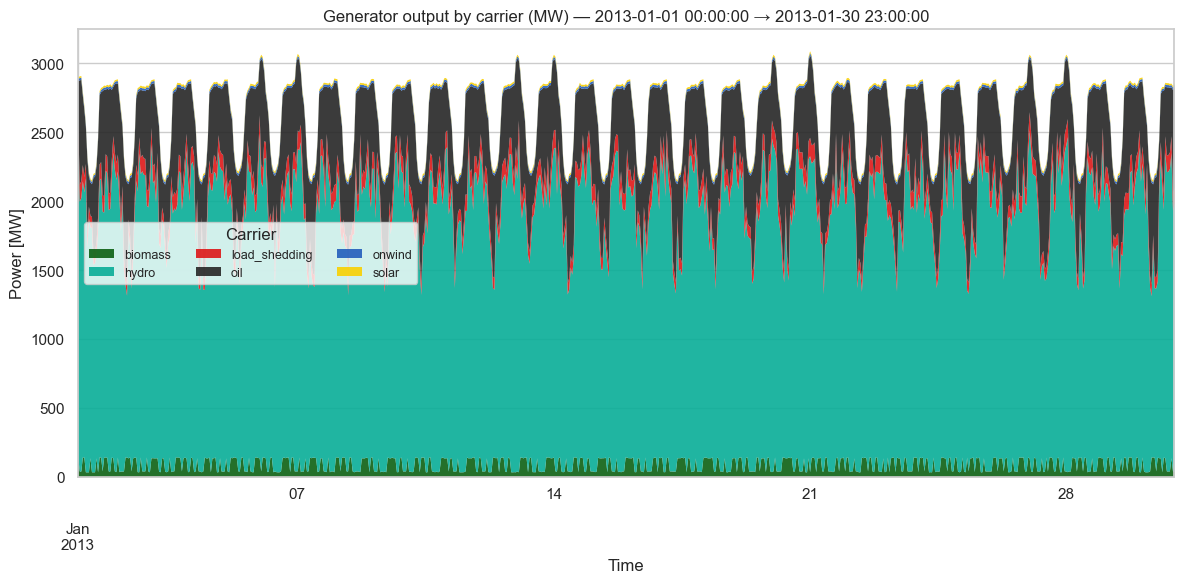

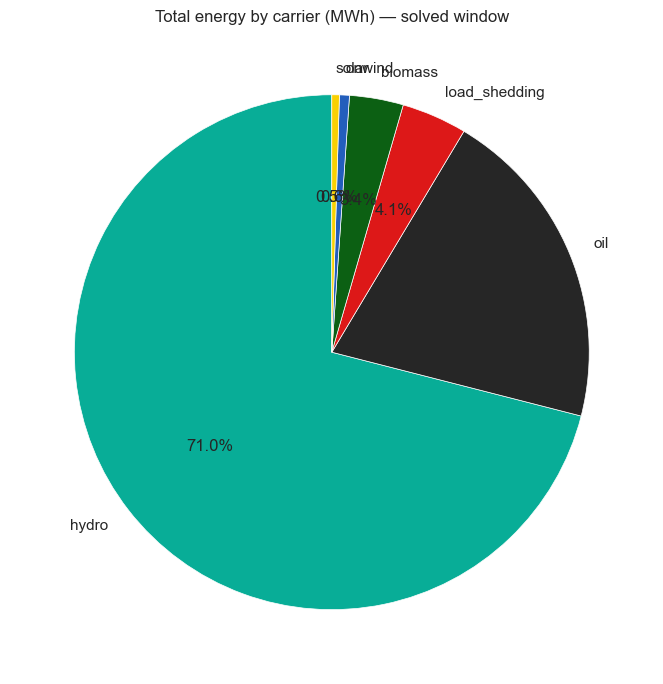

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n = network  # alias

def solved_snapshots(n, prefer=None):
    """Return the snapshots that actually have results."""
    if prefer is not None:
        return pd.Index(prefer)
    p = n.generators_t.p
    return p.index[p.notna().any(axis=1)]

# 1) pick the range to plot
try:
    # if you defined snapshots_subset earlier, use it
    plot_snaps = solved_snapshots(n, prefer=snapshots_subset)
except NameError:
    plot_snaps = solved_snapshots(n)

# 2) slice to existing data only
p = n.generators_t.p.loc[plot_snaps]                 # MW
gen_to_carrier = n.generators["carrier"].astype(str)
gen_to_carrier = gen_to_carrier.reindex(p.columns)   # align

# 3) aggregate by carrier
p_by_carrier = p.groupby(gen_to_carrier, axis=1).sum().sort_index()

# hours weighting for energy
def snapshot_hours(n, idx):
    # prefer snapshot_weightings if present
    sw = getattr(n, "snapshot_weightings", None)
    if sw is not None:
        if hasattr(sw, "columns") and "generators" in sw.columns:
            return sw.loc[idx, "generators"].astype(float)
        if isinstance(sw, pd.Series):
            return sw.loc[idx].astype(float)
    # fallback: infer from dt
    if len(idx) >= 2:
        dt = idx.to_series().diff().dt.total_seconds().shift(-1) / 3600.0
        dt.iloc[-1] = dt.iloc[-2] if len(dt) > 1 else 1.0
        return dt
    return pd.Series(1.0, index=idx)

hours = snapshot_hours(n, p_by_carrier.index)
energy_by_carrier = (p_by_carrier.mul(hours, axis=0)).sum(axis=0).sort_values(ascending=False)

# colors from carriers table (optional)
carrier_colors = {}
try:
    if hasattr(n, "carriers") and "color" in n.carriers.columns:
        carrier_colors = n.carriers["color"].dropna().astype(str).to_dict()
except Exception:
    pass
cols = [carrier_colors.get(c, None) for c in p_by_carrier.columns]

# 4) plot time series (stacked area) for the solved window only
plt.figure(figsize=(12,6))
p_by_carrier.plot.area(ax=plt.gca(), linewidth=0, alpha=0.9, color=cols)
plt.title(f"Generator output by carrier (MW) — {plot_snaps[0]} → {plot_snaps[-1]}")
plt.xlabel("Time")
plt.ylabel("Power [MW]")
plt.legend(title="Carrier", ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

# 5) pie chart: total energy over the solved window only
plt.figure(figsize=(7,7))
colors_pie = [carrier_colors.get(c, None) for c in energy_by_carrier.index]
plt.pie(
    energy_by_carrier.values,
    labels=energy_by_carrier.index,
    autopct=lambda x: f"{x:.1f}%",
    startangle=90,
    colors=colors_pie,
    wedgeprops=dict(linewidth=0.5, edgecolor="white"),
)
plt.title("Total energy by carrier (MWh) — solved window")
plt.tight_layout()
plt.show()


In [68]:
network.generators_t.p

p_by_carrier.sum()

carrier
biomass          6.439847e+04
hydro            1.352686e+06
load_shedding    7.814612e+04
oil              3.887438e+05
onwind           1.188000e+04
solar            9.003600e+03
dtype: float64

In [69]:
# Total available capacity per carrier
p_nom_by_carrier = network.generators.groupby("carrier")["p_nom"].sum().sort_values(ascending=False)
print("Installed capacity [MW]:")
print(p_nom_by_carrier)

# Compare installed capacity vs peak load
total_load = network.loads_t.p_set.sum(axis=1)
peak_load = total_load.max()
total_gen_cap = p_nom_by_carrier.sum()-p_nom_by_carrier["load_shedding"]

print(f"\nPeak load: {peak_load:.1f} MW")
print(f"Total installed generation capacity: {total_gen_cap:.1f} MW")

if total_gen_cap < peak_load:
    print("⚠️ Installed generation capacity < peak load → insufficient generation possible.")
else:
    print("✅ Installed generation capacity ≥ peak load → generation may be sufficient.")


Installed capacity [MW]:
carrier
load_shedding    1110000.00
hydro               5035.15
oil                 1958.72
biomass              142.90
solar                 23.60
onwind                16.50
Name: p_nom, dtype: float64

Peak load: 3104.6 MW
Total installed generation capacity: 7176.9 MW
✅ Installed generation capacity ≥ peak load → generation may be sufficient.


In [70]:
# Lines with heavy loading (potential congestion)
loading = abs(network.lines_t.p0 / network.lines.s_nom)
congested_lines = loading.max(axis=0)[loading.max(axis=0) > 0.9]
print(f"⚙️  Congested lines (>{90}% loading): {len(congested_lines)}")
display(congested_lines.sort_values(ascending=False))

# Transformers
if len(network.transformers):
    loading_tr = abs(network.transformers_t.p0 / network.transformers.s_nom)
    congested_tr = loading_tr.max(axis=0)[loading_tr.max(axis=0) > 0.9]
    print(f"⚙️  Congested transformers: {len(congested_tr)}")
    display(congested_tr.sort_values(ascending=False))




⚙️  Congested lines (>90% loading): 0


Series([], dtype: float64)

⚙️  Congested transformers: 0


Series([], dtype: float64)

In [71]:
# Identify buses with load_shedding generators
ls_gens = network.generators.query("carrier == 'load_shedding'")
ls_buses = ls_gens["bus"].unique()

# Total load_shedding per bus
load_shedding_by_bus = network.generators_t.p[ls_gens.index].sum()
load_shedding_by_bus = load_shedding_by_bus.groupby(ls_gens.loc[load_shedding_by_bus.index, "bus"]).sum()
load_shedding_by_bus=load_shedding_by_bus[load_shedding_by_bus>0]
load_shedding_by_bus.sort_values(ascending=False).to_csv("load_shedding_buses.csv")
# Print top affected buses
print("Top buses with load shedding:")
print(load_shedding_by_bus.sort_values(ascending=False).head(10).index)



Top buses with load shedding:
Index(['277', '280', '64'], dtype='object', name='bus')


In [72]:
import pandas as pd
import numpy as np
import networkx as nx

n = network  # alias

# --- 0) (Optional) load your explicit list of LS buses ---
ls_bus_list = load_shedding_by_bus
try:
    df_ls = pd.read_csv("load_shedding_buses.csv")
    # assume a column named 'bus' (adapt if needed)
    col = "bus" if "bus" in df_ls.columns else df_ls.columns[0]
    ls_bus_list = df_ls[col].astype(str).unique().tolist()
except Exception:
    pass  # we'll derive from the network below if not provided

# --- 1) Build a bus graph with only usable branches ---
def build_bus_graph(n: "pypsa.Network", include_links=True):
    G = nx.Graph()

    # Add all buses as nodes
    for b in n.buses.index.astype(str):
        G.add_node(b)

    # Lines (only those with positive rating)
    if len(n.lines):
        lines_ok = n.lines[(n.lines.s_nom > 0) & (~n.lines.bus0.isna()) & (~n.lines.bus1.isna())]
        for name, row in lines_ok.iterrows():
            G.add_edge(str(row.bus0), str(row.bus1), kind="line", name=name, s_nom=row.s_nom)

    # Transformers
    if len(n.transformers):
        tr_ok = n.transformers[(n.transformers.s_nom > 0) & (~n.transformers.bus0.isna()) & (~n.transformers.bus1.isna())]
        for name, row in tr_ok.iterrows():
            G.add_edge(str(row.bus0), str(row.bus1), kind="trafo", name=name, s_nom=row.s_nom)

    # Links (HVDC, etc.) if desired
    if include_links and len(n.links):
        lk_ok = n.links[(n.links.p_nom > 0) & (~n.links.bus0.isna()) & (~n.links.bus1.isna())]
        for name, row in lk_ok.iterrows():
            G.add_edge(str(row.bus0), str(row.bus1), kind="link", name=name, p_nom=row.p_nom)
    return G

G = build_bus_graph(n)

# --- 2) Identify buses with real generators (exclude load_shedding) ---
gens = n.generators.copy()
gens["bus"] = gens["bus"].astype(str)
real_gens = gens[(gens["carrier"] != "load_shedding") & (gens["p_nom"] > 0)]
gen_buses = real_gens["bus"].unique().tolist()
gen_cap_by_bus = real_gens.groupby("bus")["p_nom"].sum()

# --- 3) Get the list of load-shedding buses ---
if ls_bus_list is None:
    # derive from generators_t: find LS generators actually used or present
    ls_gens = gens[gens["carrier"] == "load_shedding"].index
    # If you want only buses with *nonzero* LS dispatch, uncomment next line:
    used = n.generators_t.p[ls_gens].sum(axis=0); ls_gens = used[used>0].index
    ls_bus_list = gens.loc[ls_gens, "bus"].astype(str).unique().tolist()

# --- 4) Component-based reachability test ---
# Precompute connected components
comp_id = {}
for i, comp in enumerate(nx.connected_components(G)):
    for b in comp:
        comp_id[b] = i

# For each component, compute number of gen buses and total gen capacity
comp_stats = {}
for b, cid in comp_id.items():
    comp_stats.setdefault(cid, {"gen_buses": set(), "gen_cap": 0.0})
for b, cap in gen_cap_by_bus.items():
    cid = comp_id.get(b)
    if cid is not None:
        comp_stats[cid]["gen_buses"].add(b)
        comp_stats[cid]["gen_cap"] += float(cap)

# Build result table for LS buses
rows = []
for b in ls_bus_list:
    cid = comp_id.get(str(b), None)
    if cid is None:
        rows.append({"bus": str(b), "component": np.nan, "reachable_real_gen": False,
                     "gens_in_component": 0, "gen_cap_in_component_MW": 0.0})
        continue
    gens_in_comp = len(comp_stats[cid]["gen_buses"])
    cap_in_comp  = comp_stats[cid]["gen_cap"]
    reachable = gens_in_comp > 0 and cap_in_comp > 0
    rows.append({"bus": str(b), "component": cid, "reachable_real_gen": reachable,
                 "gens_in_component": gens_in_comp, "gen_cap_in_component_MW": cap_in_comp})

ls_reach = pd.DataFrame(rows).sort_values(["reachable_real_gen","gen_cap_in_component_MW"], ascending=[True, False])
print("Load-shedding buses connectivity summary:")
display(ls_reach.head(20))

# Save for audit if you like
ls_reach.to_csv("load_shedding_buses_connectivity.csv", index=False)


Load-shedding buses connectivity summary:


,bus,component,reachable_real_gen,gens_in_component,gen_cap_in_component_MW
0,277,1,True,1,35.20
2,64,1,True,1,35.20
1,280,5,True,1,1.76


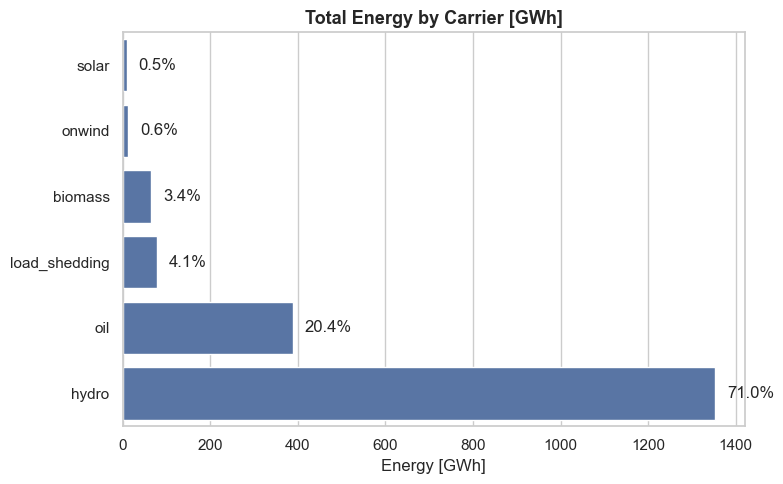

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Compute totals by carrier ---
p_by_carrier = network.generators_t.p.groupby(network.generators["carrier"], axis=1).sum()
total_by_carrier = p_by_carrier.sum() / 1e3  # GWh
total_sum = total_by_carrier.sum()

# --- Prepare sorted dataframe for seaborn ---
df_plot = (
    total_by_carrier.reset_index()
    .rename(columns={"index": "carrier", 0: "energy_gwh"})
)
df_plot.columns = ["carrier", "energy_gwh"]
df_plot["percentage"] = 100 * df_plot["energy_gwh"] / total_sum
df_sorted = df_plot.sort_values("energy_gwh", ascending=True)

# --- Plot with explicit order ---
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
ax = sns.barplot(
    data=df_sorted,
    y="carrier",
    x="energy_gwh",
    order=df_sorted["carrier"].tolist(),  # ensure order
)

# --- Annotations aligned with bars (iterate bars in plotted order) ---
xmax = df_sorted["energy_gwh"].max()
for bar, (_, row) in zip(ax.patches, df_sorted.iterrows()):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        x + 0.02 * xmax,  # small offset from bar end
        y,
        f"{row['percentage']:.1f}%",
        va="center",
        ha="left",
        clip_on=False,
    )

# --- Labels and layout ---
ax.set_title("Total Energy by Carrier [GWh]", fontsize=13, weight="bold")
ax.set_xlabel("Energy [GWh]")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


In [74]:
df_sorted

,carrier,energy_gwh,percentage
5,solar,9.003600,0.472665
4,onwind,11.880000,0.623669
0,biomass,64.398470,3.380750
2,load_shedding,78.146124,4.102465
3,oil,388.743848,20.408025
1,hydro,1352.685677,71.012426


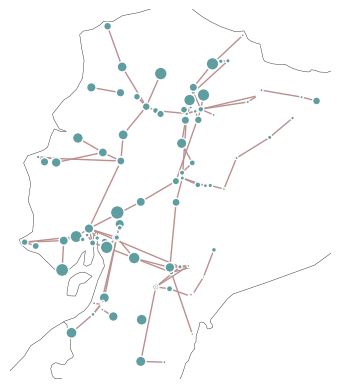

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Build bus_sizes from loads (sum over time), with index dtype aligned ---
# 1) totals per LOAD
load_totals = network.loads_t.p.sum()                  # index: load_id

# 2) map load -> bus, making sure dtype matches network.buses.index
bus_index_dtype = network.buses.index.dtype
load_to_bus = network.loads["bus"].astype(bus_index_dtype)

# 3) aggregate to BUS and reindex to full bus list
bus_sizes = load_totals.groupby(load_to_bus).sum()
bus_sizes = bus_sizes.reindex(network.buses.index).fillna(0)
bus_sizes = bus_sizes*100/max(bus_sizes)
# 4) scale for plotting
bus_sizes = 1e-4* bus_sizes

# (optional) sanity check
# print("bus_sizes dtype:", bus_sizes.index.dtype, "| buses dtype:", network.buses.index.dtype)

# --- Plot ---
network.plot(bus_sizes=bus_sizes, line_widths=1)
plt.show()


In [76]:
import pandas as pd
import numpy as np
import pandas as pd

# Time-series flows (snapshots x lines)
p0 = network.lines_t.p0  # MW

# Continuous ratings per line (Series indexed by line)
s_nom = network.lines["s_nom"]  # MVA (PyPSA convention); assume MW≈MVA if PF≈1

# Avoid division by zero/NaN
s_nom_safe = s_nom.replace({0: np.nan})

# Max loading over time per line (fraction of rating)
line_loading_max = p0.abs().div(s_nom_safe, axis=1).max(axis=0)

# Optional: as percent
line_loading_max_ = 100 * line_loading_max
line_loading_max.to_csv("line_loading.csv")

In [77]:
import pandas as pd
import numpy as np

# --- Transformer loading analysis ---

# Time-series flows (snapshots × transformers)
p0_trafo = network.transformers_t.p0  # MW

# Continuous ratings per transformer (MVA, indexed by transformer)
s_nom_trafo = network.transformers["s_nom"]

# Avoid division by zero / NaN
s_nom_trafo_safe = s_nom_trafo.replace({0: np.nan})

# Max loading over time per transformer (fraction of nominal rating)
trafo_loading_max = p0_trafo.abs().div(s_nom_trafo_safe, axis=1).max(axis=0)

# Optional: convert to percent
trafo_loading_max_pct = 100 * trafo_loading_max

# Save to CSV
trafo_loading_max_pct.to_csv("trafo_loading.csv")

# Print top-loaded transformers
print(trafo_loading_max_pct.sort_values(ascending=False).head(10).round(1))


Transformer
transf_45_1    49.7
transf_10_2    28.4
transf_10_1    13.0
transf_45_0    10.3
transf_2_0     10.2
transf_49_1     8.3
transf_3_1      8.2
transf_42_0     7.2
transf_9_1      6.3
transf_5_0      4.8
dtype: float64


In [78]:

# Add to lines DataFrame for reference
network.lines["max_loading"] = line_loading_max

# Get top 5
top5 = network.lines.sort_values("max_loading", ascending=False).head(5)

# Display concise table
cols = ["bus0", "bus1", "max_loading", "length", "v_nom"]
print("Top 5 most loaded lines:")
display(top5[cols])
for i, row in top5.iterrows():
    print(f"{i}: {row.bus0} ↔ {row.bus1} | loading={row.max_loading:.2f} p.u. | length={row.length:.1f} km")


Top 5 most loaded lines:


,bus0,bus1,max_loading,length,v_nom
Line,,,,,
90,64,277,0.7,22.914154,138.0
84,38,273,0.7,9.036811,138.0
81,146,24,0.7,24.288375,138.0
3,111,7,0.7,8.552634,138.0
82,146,271,0.7,13.892487,138.0


90: 64 ↔ 277 | loading=0.70 p.u. | length=22.9 km
84: 38 ↔ 273 | loading=0.70 p.u. | length=9.0 km
81: 146 ↔ 24 | loading=0.70 p.u. | length=24.3 km
3: 111 ↔ 7 | loading=0.70 p.u. | length=8.6 km
82: 146 ↔ 271 | loading=0.70 p.u. | length=13.9 km


In [79]:
network.lines[["bus0", "bus1", "length", "v_nom", "carrier"]].to_csv("lines_meta.csv")

network.transformers[["bus0", "bus1"]].to_csv("trafos_meta.csv")
network.buses[["v_nom", "lon", "lat"]].to_csv("buses_meta.csv")

In [80]:
import pandas as pd

# Load data
lines = pd.read_csv("line_loading.csv", index_col=0)
lines_meta = pd.read_csv("lines_meta.csv", index_col=0)
trafos = pd.read_csv("trafo_loading.csv", index_col=0)
trafos_meta = pd.read_csv("trafos_meta.csv", index_col=0)
buses = pd.read_csv("buses_meta.csv", index_col=0)

# Merge metadata
lines_full = lines_meta.join(lines, how="left")
trafos_full = trafos_meta.join(trafos, how="left")

# Rename columns
lines_full.columns = [c if c != lines_full.columns[-1] else "max_loading_pct"
                      for c in lines_full.columns]
trafos_full.columns = [c if c != trafos_full.columns[-1] else "max_loading_pct"
                       for c in trafos_full.columns]
print("=== Line Loading Summary ===")
print(lines_full["max_loading_pct"].describe())

print("\n=== Transformer Loading Summary ===")
print(trafos_full["max_loading_pct"].describe())

# Congestion ratio
n_lines = len(lines_full)
n_trafos = len(trafos_full)
high_lines = (lines_full["max_loading_pct"] > 90).sum()
high_trafos = (trafos_full["max_loading_pct"] > 90).sum()

print(f"\nLines >90% loaded: {high_lines}/{n_lines} ({100*high_lines/n_lines:.1f}%)")
print(f"Transformers >90% loaded: {high_trafos}/{n_trafos} ({100*high_trafos/n_trafos:.1f}%)")
print("\n=== Top 10 Congested Lines ===")
print(lines_full.sort_values("max_loading_pct", ascending=False).head(10))

print("\n=== Top 10 Congested Transformers ===")
print(trafos_full.sort_values("max_loading_pct", ascending=False).head(10))
# Merge voltage info for bus0
lines_full = lines_full.join(
    buses[["v_nom", "lon", "lat"]].add_prefix("bus0_"),
    on="bus0"
)
lines_full = lines_full.join(
    buses[["v_nom", "lon", "lat"]].add_prefix("bus1_"),
    on="bus1"
)

# Average loading per voltage level
voltage_summary = lines_full.groupby("v_nom")["max_loading_pct"].mean()
print("\nAverage line loading per voltage level:\n", voltage_summary)


=== Line Loading Summary ===
count    106.000000
mean       0.232760
std        0.203426
min        0.002051
25%        0.053563
50%        0.170688
75%        0.344319
max        0.700000
Name: max_loading_pct, dtype: float64

=== Transformer Loading Summary ===
count    19.000000
mean      8.316204
std      12.061611
min       0.000000
25%       1.466610
50%       4.837090
75%       9.249842
max      49.697214
Name: max_loading_pct, dtype: float64

Lines >90% loaded: 0/106 (0.0%)
Transformers >90% loaded: 0/19 (0.0%)

=== Top 10 Congested Lines ===
      bus0  bus1     length  v_nom carrier  max_loading_pct
Line                                                       
90      64   277  22.914154  138.0      AC         0.700000
84      38   273   9.036811  138.0      AC         0.700000
81     146    24  24.288375  138.0      AC         0.700000
3      111     7   8.552634  138.0      AC         0.700000
82     146   271  13.892487  138.0      AC         0.700000
155     47    65  20.99

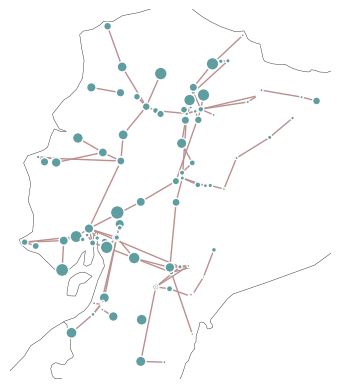

In [81]:
network.plot(bus_sizes=bus_sizes, line_widths=1)
plt.show()

In [82]:
lines_load = pd.read_csv("line_loading.csv", index_col=0)
lines_load*=100
lines_load

,0
Line,
0,13.547859
1,49.167209
2,26.756393
3,70.000000
4,36.056259
...,...
242,27.671630
243,5.346415
244,2.535179


Matched 106 / 106 lines; missing 0.


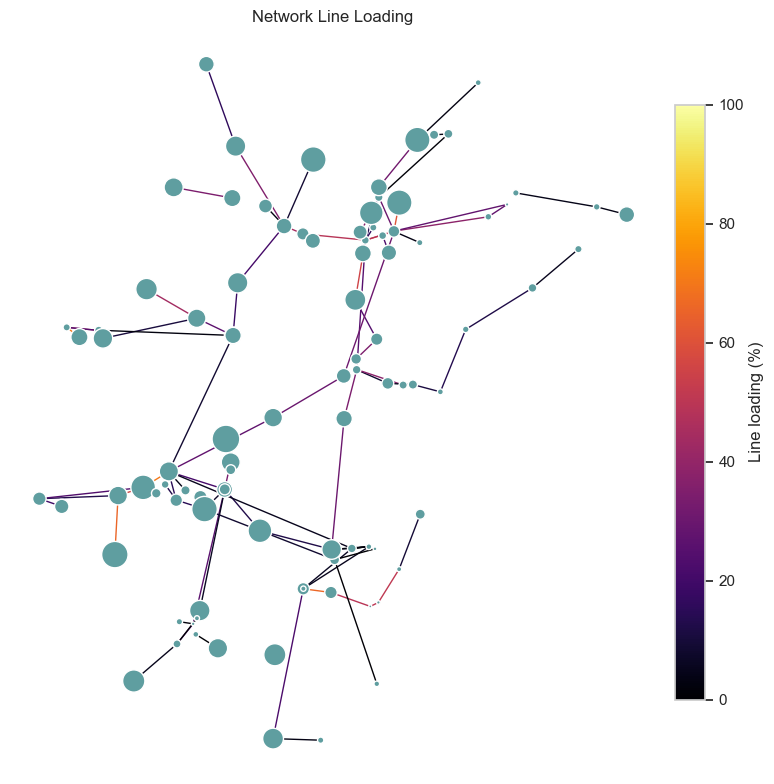

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Load your line loading data (first column as Series) ---
lines_raw = pd.read_csv("line_loading.csv", index_col=0).iloc[:, 0].astype(float)  # e.g. 0..1
lines_raw *= 100.0  # -> %
# lines_raw = np.clip(lines_raw, 0, 150)

# --- Canonicalize indexes to strings on BOTH sides ---
def canon_idx(idx):
    return pd.Index(idx.astype(str).str.strip())

csv_idx = canon_idx(lines_raw.index)
net_idx = canon_idx(network.lines.index)

# Put canonical index on the data
lines_canon = lines_raw.copy()
lines_canon.index = csv_idx

# --- Align by label, keep the network’s order ---
aligned = lines_canon.reindex(net_idx)

# Diagnostics
matched = aligned.notna().sum()
missing = aligned.isna().sum()
print(f"Matched {matched} / {len(aligned)} lines; missing {missing}.")

# Optional: peek mismatches
if missing:
    csv_only = set(lines_canon.index) - set(net_idx)
    net_only = set(net_idx) - set(lines_canon.index)
    print("Examples only-in-CSV:", list(csv_only)[:5])
    print("Examples only-in-NET:", list(net_only)[:5])

# Fill missing with 0 (or choose another strategy)
aligned = aligned.fillna(0.0)

# --- Build a Series using the network’s ORIGINAL index (not canonical) ---
line_colors = pd.Series(aligned.values, index=network.lines.index)

# --- Plot ---
cmap = "inferno"
norm = plt.Normalize(vmin=0, vmax=100)

fig, ax = plt.subplots(figsize=(10, 8))
network.plot(
    ax=ax,
    geomap=False,
    bus_sizes=bus_sizes,
    line_colors=line_colors,   # <- index matches network.lines.index
    line_cmap=cmap,
    line_norm=norm,
    line_widths=1,
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02).set_label("Line loading (%)")
plt.title("Network Line Loading")
plt.tight_layout()
plt.show()


In [84]:
nl = network
mis = nl.buses_t.p.sum() - (
    nl.loads_t.p_set.sum(axis=1)
  + nl.generators_t.p.sum(axis=1)
  + nl.storage_units_t.p.sum(axis=1)
)
mis.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [85]:
duals = network.buses_t.p

duals


Bus,1,3,4,5,7,8,10,11,12,14,...,273,277,278,279,280,281,288,291,292,294
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-37.043089,-24.986789,-9.751626,0.0,-8.433333,0.0,-60.576016,-10.293902,0.0,-15.618496,...,107.91889,104.921138,-87.862805,-4.871138,32.667480,-31.391260,1.773415,-49.791260,-3.608943,-1.977439
2013-01-01 01:00:00,-37.089837,-25.019512,-9.765650,0.0,-8.442683,0.0,-60.646138,-3.743252,0.0,-15.641870,...,107.91889,105.061382,-87.975000,-4.880488,32.709553,-13.038659,1.759390,-49.847358,-3.613618,-1.982114
2013-01-01 02:00:00,-37.127236,-25.047561,-9.775000,0.0,-8.452033,0.0,-60.716260,-3.757276,0.0,-15.655894,...,107.91889,105.173577,-88.073171,-4.885163,32.746951,-31.466057,1.745366,-49.908130,-3.613618,-1.982114
2013-01-01 03:00:00,-35.701423,-24.084553,-9.401016,0.0,-8.129472,0.0,-58.374187,-3.359919,0.0,-15.052846,...,107.91889,101.125203,-81.624593,-4.698171,31.484756,-30.250610,2.203496,-47.986789,-3.478049,-1.907317
2013-01-01 04:00:00,-34.397154,-23.201016,-9.055081,0.0,-7.830285,0.0,-56.237805,-2.995285,0.0,-14.505894,...,107.91889,97.436789,-78.539228,-4.525203,30.334756,-10.757358,2.624228,-46.233740,-3.351829,-1.837195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-12-31 20:00:00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-12-31 21:00:00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [86]:
import pandas as pd
import numpy as np

n = network  # just a shorthand

# 1) Identify load shedding generators
ls_gen = n.generators[n.generators.carrier == "load_shedding"].copy()
ls_gen_indices = ls_gen.index

# 2) Time series of load shedding (MW)
ls_p = n.generators_t.p[ls_gen_indices]   # snapshots x LS generators

# 3) Total LS per snapshot (MW)
ls_total = ls_p.sum(axis=1)

# 4) Hours where LS is actually > 0
threshold = 1e-3  # MW
ls_hours = ls_total[ls_total > threshold].index
print(f"Hours with load shedding: {len(ls_hours)}")


Hours with load shedding: 720


In [87]:
# Nodal marginal prices [same units as marginal_cost]
mp = n.buses_t.marginal_price  # snapshots x buses

# Buses where LS gens are located
ls_buses = ls_gen["bus"].unique()

# Marginal prices only at LS buses, at LS hours
mp_ls = mp.loc[ls_hours, ls_buses]

print("Marginal price stats at load-shedding buses during LS hours:")
print(mp_ls.describe())
# Collapse to a single representative marginal price per hour at LS buses,
# e.g. average or max. Let's take max to capture worst scarcity.
mp_ls_max = mp_ls.max(axis=1)

df_ls = pd.DataFrame({
    "load_shedding_MW": ls_total.loc[ls_hours],
    "scarcity_price": mp_ls_max,
})
print(df_ls.head())
print(df_ls.describe())

# Optional: correlation between LS magnitude and price
print(df_ls.corr())

Marginal price stats at load-shedding buses during LS hours:
           1      3      4      5      7      8     10     11     12     14  \
count  720.0  720.0  720.0  720.0  720.0  720.0  720.0  720.0  720.0  720.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min     -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   
25%     -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   
50%     -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
max     -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   -0.0   

       ...    273        277    278    279        280    281    288    291  \
count  ...  720.0      720.0  720.0  720.0      720.0  720.0  720.0  720.0   
mean   ...    0.0  1000000.0    0.0    0.0  1000000.0    0.0    0.0    

In [88]:
bus_list = ["280"]
n = network  # your PyPSA network
import pandas as pd


# Normalize to string on both sides to avoid int/str issues
load_mask = n.loads.bus.astype(str).isin(bus_list)
loads_on_buses = n.loads[load_mask]

print("Loads on buses", bus_list)
print(loads_on_buses)
# Lines where either bus0 or bus1 is in the list
lines_mask = (
    n.lines.bus0.astype(str).isin(bus_list) |
    n.lines.bus1.astype(str).isin(bus_list)
)
lines_touching = n.lines[lines_mask]

print("Lines touching buses", bus_list)
print(lines_touching[["bus0", "bus1", "s_nom", "v_nom"]])

if hasattr(n, "transformers") and not n.transformers.empty:
    trafo_mask = (
        n.transformers.bus0.astype(str).isin(bus_list) |
        n.transformers.bus1.astype(str).isin(bus_list)
    )
    trafos_touching = n.transformers[trafo_mask]

    print("Transformers touching buses", bus_list)
    print(trafos_touching[["bus0", "bus1"]])
else:
    print("No transformers in network (n.transformers is empty).")



Loads on buses ['280']
      bus carrier type  p_set  q_set  sign
Load                                      
280   280                 0.0    0.0  -1.0
Lines touching buses ['280']
     bus0 bus1       s_nom  v_nom
Line                             
114   165  280  154.169842  138.0
Transformers touching buses ['280']
Empty DataFrame
Columns: [bus0, bus1]
Index: []


In [89]:
network.lines.to_csv("network_lines.csv")

In [90]:
if hasattr(n, "transformers") and not n.transformers.empty:
    trafo_mask = (
        n.transformers.bus0.astype(str).isin(bus_list) |
        n.transformers.bus1.astype(str).isin(bus_list)
    )
    trafos_touching = n.transformers[trafo_mask]

    print("Transformers touching buses", bus_list)
    print(trafos_touching[["bus0", "bus1", "s_nom", "v_nom", "v_nom0", "v_nom1"]])
else:
    print("No transformers in network (n.transformers is empty).")


Transformers touching buses ['280']


KeyError: "['v_nom', 'v_nom0', 'v_nom1'] not in index"